In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pickle
import os

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

In [3]:
transactions = pd.read_csv('../data/data/transaction_fact_20250325.csv')
world_transactions = pd.read_csv('../data/data/wrld_stor_tran_fact_20250325.csv')

In [4]:
all_transactions = pd.concat([transactions, world_transactions], ignore_index=True)
print(f"Row: {all_transactions.shape[0]}, Column: {all_transactions.shape[1]}")

Row: 1547190, Column: 21


In [5]:
# Check the range of transaction dates, ensuring sufficient historical data
print("\nCheck transaction date range:")
all_transactions['transaction_date'] = pd.to_datetime(all_transactions['transaction_date'])
print(f"Earliest transaction date: {all_transactions['transaction_date'].min()}")
print(f"Latest transaction date: {all_transactions['transaction_date'].max()}")


Check transaction date range:
Earliest transaction date: 2023-02-17 00:00:00
Latest transaction date: 2025-03-24 00:00:00


In [6]:
# Check the number of accounts
print(f"\nTotal number of accounts: {all_transactions['current_account_nbr'].nunique()}")
# Check the transaction type distribution
print("\nTransaction type distribution:")
print(all_transactions['transaction_type'].value_counts())


Total number of accounts: 14283

Transaction type distribution:
transaction_type
SALE          1360053
PAYMENT        120876
RETURN          39837
ADJUSTMENT      26424
Name: count, dtype: int64


In [7]:
essential_columns = [
    'current_account_nbr', 
    'transaction_date', 
    'transaction_amt', 
    'transaction_type',
    'transaction_code'
]
transactions_subset = all_transactions[essential_columns]
print("\nPrepare data subset for time series analysis:")
print(transactions_subset.head())


Prepare data subset for time series analysis:
  current_account_nbr transaction_date  transaction_amt transaction_type  transaction_code
0    X7jfKh6xrPAB8Tx6       2024-06-05            15.78             SALE               253
1    yntD77AZDylS48Q4       2024-06-19            14.85             SALE               253
2    LIJPI0sK28Pa7fX2       2024-06-26           136.16             SALE               253
3    CMAr5Apxwdzpvoze       2024-08-15             8.74             SALE               253
4    eJSfTCGPvJulGzd3       2024-08-17            26.65             SALE               253


In [8]:
transactions_subset.to_csv('prepared_transactions.csv', index=False)

In [9]:
transactions = pd.read_csv('prepared_transactions.csv')
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])

In [10]:
transactions['year_month'] = transactions['transaction_date'].dt.strftime('%Y-%m')

In [11]:
monthly_spending = transactions.groupby(['current_account_nbr', 'year_month'])['transaction_amt'].sum().reset_index()
print(f"Aggregated data set: row number: {monthly_spending.shape[0]}")
print(monthly_spending.head())

Aggregated data set: row number: 113747
  current_account_nbr year_month  transaction_amt
0    00gwujJkd597VxLd    2025-03            25.90
1    00iP5U82D8XwVQ9G    2024-03            93.23
2    00iP5U82D8XwVQ9G    2024-04           758.42
3    00iP5U82D8XwVQ9G    2024-05           381.44
4    00iP5U82D8XwVQ9G    2024-06           191.73


In [12]:
# Get the earliest and latest dates in the data
start_date = transactions['transaction_date'].min()
end_date = transactions['transaction_date'].max()
print(f"Data time range: {start_date} to {end_date}")

Data time range: 2023-02-17 00:00:00 to 2025-03-24 00:00:00


In [13]:
# Create a complete month sequence
all_months = pd.date_range(start=start_date, end=end_date, freq='MS').strftime('%Y-%m').tolist()
print(f"Total number of months: {len(all_months)}")

Total number of months: 25


In [14]:
# Get all account numbers
all_accounts = transactions['current_account_nbr'].unique()
print(f"Total number of accounts: {len(all_accounts)}")

Total number of accounts: 14283


In [15]:
# Create a complete time series framework that includes all accounts and all months
print("Create a complete time series framework...")
account_month_grid = pd.MultiIndex.from_product([all_accounts, all_months], names=['current_account_nbr', 'year_month'])
complete_time_series = pd.DataFrame(index=account_month_grid).reset_index()

Create a complete time series framework...


In [16]:
# Merge the aggregated consumption data into the complete time series framework
print("Merge actual consumption data...")
complete_time_series = complete_time_series.merge(monthly_spending, on=['current_account_nbr', 'year_month'], how='left')

Merge actual consumption data...


In [17]:
# Fill missing consumption data with 0 (assuming no consumption records mean no consumption)
complete_time_series['transaction_amt'] = complete_time_series['transaction_amt'].fillna(0)

In [18]:
complete_time_series['date'] = pd.to_datetime(complete_time_series['year_month'] + '-01')
complete_time_series['year'] = complete_time_series['date'].dt.year
complete_time_series['month'] = complete_time_series['date'].dt.month
complete_time_series['quarter'] = complete_time_series['date'].dt.quarter

In [19]:
print("\nProcessed time series data:")
print(complete_time_series.head())


Processed time series data:
  current_account_nbr year_month  transaction_amt       date  year  month  quarter
0    X7jfKh6xrPAB8Tx6    2023-03              0.0 2023-03-01  2023      3        1
1    X7jfKh6xrPAB8Tx6    2023-04              0.0 2023-04-01  2023      4        2
2    X7jfKh6xrPAB8Tx6    2023-05              0.0 2023-05-01  2023      5        2
3    X7jfKh6xrPAB8Tx6    2023-06              0.0 2023-06-01  2023      6        2
4    X7jfKh6xrPAB8Tx6    2023-07              0.0 2023-07-01  2023      7        3


In [20]:
# Verify that each account has complete monthly records
account_month_counts = complete_time_series.groupby('current_account_nbr').size()
print(f"\nEach account's monthly record number is consistent: {(account_month_counts == len(all_months)).all()}")


Each account's monthly record number is consistent: True


In [21]:
latest_8_months = pd.date_range(end=end_date, periods=8, freq='MS').strftime('%Y-%m').tolist()
recent_data = complete_time_series[complete_time_series['year_month'].isin(latest_8_months)]

Saved to sample_accounts_spending.png


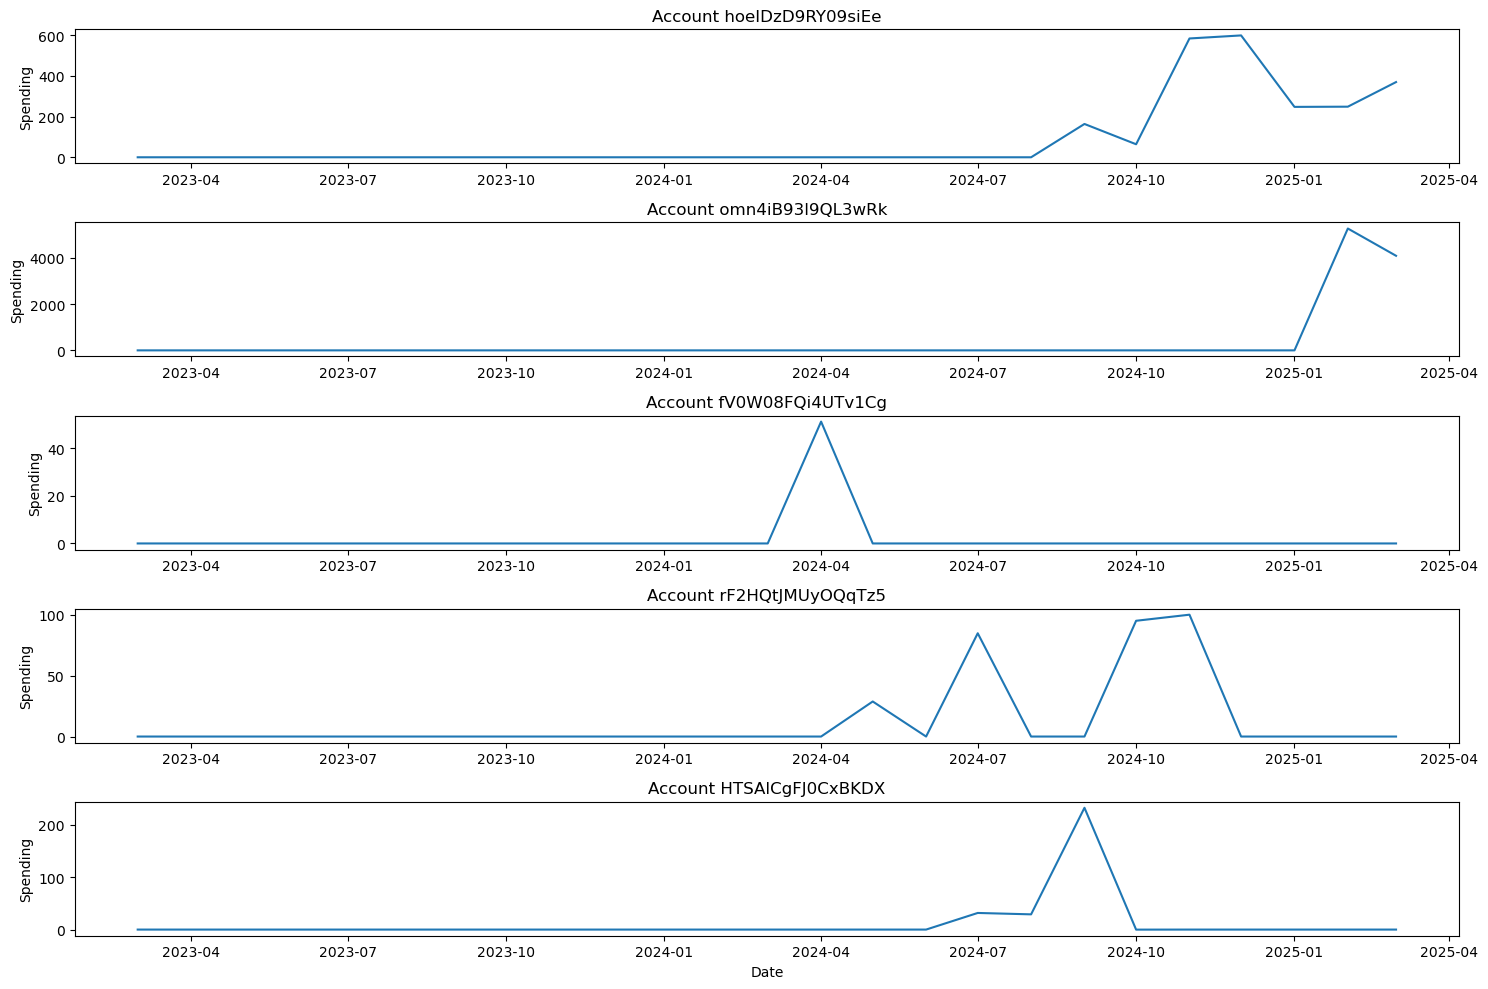

In [22]:
random_accounts = np.random.choice(all_accounts, min(5, len(all_accounts)), replace=False)
plt.figure(figsize=(15, 10))
for i, account in enumerate(random_accounts):
    account_data = complete_time_series[complete_time_series['current_account_nbr'] == account]
    plt.subplot(len(random_accounts), 1, i+1)
    plt.plot(account_data['date'], account_data['transaction_amt'])
    plt.title(f'Account {account}')
    plt.ylabel('Spending')
    if i == len(random_accounts) - 1:
        plt.xlabel('Date')
plt.tight_layout()
plt.savefig('sample_accounts_spending.png')
print("Saved to sample_accounts_spending.png")

In [23]:
complete_time_series.to_csv('monthly_spending_time_series.csv', index=False)
print("\nSaved to monthly_spending_time_series.csv")


Saved to monthly_spending_time_series.csv


In [24]:
ts_data = pd.read_csv('monthly_spending_time_series.csv')
ts_data['date'] = pd.to_datetime(ts_data['date'])

In [25]:
ts_data = ts_data.sort_values(['current_account_nbr', 'date'])

In [26]:
print("Create lag features...")
for lag in range(1, 13):
    ts_data[f'lag_{lag}'] = ts_data.groupby('current_account_nbr')['transaction_amt'].shift(lag)


Create lag features...


In [27]:
print("Create rolling mean features...")
for window in [3, 6, 12]:
    ts_data[f'rolling_mean_{window}'] = ts_data.groupby('current_account_nbr')['transaction_amt'].transform(
        lambda x: x.rolling(window=window, min_periods=1).mean())
    ts_data[f'rolling_std_{window}'] = ts_data.groupby('current_account_nbr')['transaction_amt'].transform(
        lambda x: x.rolling(window=window, min_periods=1).std())


Create rolling mean features...


In [28]:
print("Create year-over-year growth features...")
ts_data['last_year_same_month'] = ts_data.groupby(['current_account_nbr', 'month'])['transaction_amt'].shift(12)
ts_data['last_year_same_quarter'] = ts_data.groupby(['current_account_nbr', 'quarter'])['transaction_amt'].shift(4)


Create year-over-year growth features...


In [29]:
print("Create month-over-month growth features...")
ts_data['month_over_month_growth'] = ts_data.groupby('current_account_nbr')['transaction_amt'].pct_change()
ts_data['year_over_year_growth'] = (ts_data['transaction_amt'] - ts_data['last_year_same_month']) / (ts_data['last_year_same_month'] + 1e-10)  # 避免除以0


Create month-over-month growth features...


In [30]:
print("Create seasonal features...")
month_dummies = pd.get_dummies(ts_data['month'], prefix='month', drop_first=False)
quarter_dummies = pd.get_dummies(ts_data['quarter'], prefix='quarter', drop_first=False)
ts_data = pd.concat([ts_data, month_dummies, quarter_dummies], axis=1)


Create seasonal features...


In [31]:
ts_data['is_holiday_season'] = ts_data['month'].isin([11, 12]).astype(int)

In [32]:
ts_data['is_q4'] = (ts_data['quarter'] == 4).astype(int)

In [33]:
print("Extract seasonal components...")
accounts_with_history = ts_data.groupby('current_account_nbr').size()
accounts_with_history = accounts_with_history[accounts_with_history >= 24].index.tolist()
sample_accounts = np.random.choice(accounts_with_history, min(5, len(accounts_with_history)), replace=False)

for account in sample_accounts:
    account_data = ts_data[ts_data['current_account_nbr'] == account].copy()
    if len(account_data) >= 24:
        try:
            decomposition = seasonal_decompose(account_data.set_index('date')['transaction_amt'], model='additive', period=12)
            
            plt.figure(figsize=(12, 10))
            plt.subplot(411)
            plt.plot(decomposition.observed)
            plt.title(f'Account {account} - Observed')
            
            plt.subplot(412)
            plt.plot(decomposition.trend)
            plt.title('Trend')
            
            plt.subplot(413)
            plt.plot(decomposition.seasonal)
            plt.title('Seasonality')
            
            plt.subplot(414)
            plt.plot(decomposition.resid)
            plt.title('Residuals')
            
            plt.tight_layout()
            plt.savefig(f'seasonality_account_{account}.png')
            plt.close()
            
            seasonal_values = decomposition.seasonal
            seasonal_dict = {date: value for date, value in zip(account_data['date'], seasonal_values)}
            ts_data.loc[ts_data['current_account_nbr'] == account, 'seasonal_component'] = ts_data.loc[ts_data['current_account_nbr'] == account, 'date'].map(seasonal_dict)
        except:
            print(f"Cannot extract seasonal components for account {account}")


Extract seasonal components...


In [34]:
print("Create trend features...")
ts_data['recent_3m_to_12m_ratio'] = ts_data['rolling_mean_3'] / (ts_data['rolling_mean_12'] + 1e-10)
ts_data['recent_6m_to_12m_ratio'] = ts_data['rolling_mean_6'] / (ts_data['rolling_mean_12'] + 1e-10)


Create trend features...


In [35]:
ts_data['volatility'] = ts_data['rolling_std_12'] / (ts_data['rolling_mean_12'] + 1e-10)
print("Calculate feature correlation...")
numeric_columns = ts_data.select_dtypes(include=[np.number]).columns
correlation_matrix = ts_data[numeric_columns].sample(min(10000, len(ts_data))).corr()


plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig('feature_correlation.png')
plt.close()
print("Saved to feature_correlation.png")



ts_data.to_csv('time_series_features.csv', index=False)


latest_date = ts_data['date'].max()


cutoff_date = pd.Timestamp('2025-08-01')
training_data = ts_data[ts_data['date'] < cutoff_date]

training_data.to_csv('training_data.csv', index=False)

Calculate feature correlation...
Saved to feature_correlation.png


In [36]:
ts_data = pd.read_csv('time_series_features.csv')
ts_data['date'] = pd.to_datetime(ts_data['date'])


min_date = ts_data['date'].min()
max_date = ts_data['date'].max()

quarters_summary = ts_data.groupby([ts_data['date'].dt.year.rename('year_val'), 
                                   ts_data['date'].dt.quarter.rename('quarter_val')])['transaction_amt'].count().reset_index()


train_data = ts_data[(ts_data['date'] < '2024-10-01')]
validation_data = ts_data[(ts_data['date'] >= '2024-10-01') & (ts_data['date'] <= '2024-12-31')]



train_accounts = set(train_data['current_account_nbr'].unique())
val_accounts = set(validation_data['current_account_nbr'].unique())

missing_counts = train_data.isnull().sum()

lag_columns = [col for col in train_data.columns if col.startswith('lag_')]
train_data[lag_columns] = train_data[lag_columns].fillna(0)
validation_data[lag_columns] = validation_data[lag_columns].fillna(0)

rolling_columns = [col for col in train_data.columns if col.startswith('rolling_')]
train_data[rolling_columns] = train_data[rolling_columns].fillna(0)
validation_data[rolling_columns] = validation_data[rolling_columns].fillna(0)

train_data['month_over_month_growth'] = train_data['month_over_month_growth'].fillna(0)
train_data['year_over_year_growth'] = train_data['year_over_year_growth'].fillna(0)
validation_data['month_over_month_growth'] = validation_data['month_over_month_growth'].fillna(0)
validation_data['year_over_year_growth'] = validation_data['year_over_year_growth'].fillna(0)

numeric_cols = train_data.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if col in train_data.columns and train_data[col].isnull().sum() > 0:
        median_value = train_data[col].median()
        train_data[col] = train_data[col].fillna(median_value)
        validation_data[col] = validation_data[col].fillna(median_value)

missing_counts = train_data.isnull().sum()

prediction_ready_data = ts_data[ts_data['date'] <= '2025-08-31']

for col in lag_columns + rolling_columns:
    if col in prediction_ready_data.columns:
        prediction_ready_data[col] = prediction_ready_data[col].fillna(0)

if 'month_over_month_growth' in prediction_ready_data.columns:
    prediction_ready_data['month_over_month_growth'] = prediction_ready_data['month_over_month_growth'].fillna(0)
if 'year_over_year_growth' in prediction_ready_data.columns:
    prediction_ready_data['year_over_year_growth'] = prediction_ready_data['year_over_year_growth'].fillna(0)

for col in numeric_cols:
    if col in prediction_ready_data.columns and prediction_ready_data[col].isnull().sum() > 0:
        median_value = prediction_ready_data[col].median()
        prediction_ready_data[col] = prediction_ready_data[col].fillna(median_value)

print("\nPrepare model features and target variables...")
exclude_cols = ['current_account_nbr', 'year_month', 'date', 'transaction_amt',
                'year', 'month', 'quarter', 'is_q4']

exclude_cols = [col for col in exclude_cols if col in train_data.columns]

X_train = train_data.drop(exclude_cols, axis=1)
y_train = train_data['transaction_amt']

X_val = validation_data.drop(exclude_cols, axis=1)
y_val = validation_data['transaction_amt']

train_data.to_csv('train_data.csv', index=False)
validation_data.to_csv('validation_data.csv', index=False)
prediction_ready_data.to_csv('prediction_ready_data.csv', index=False)

X_train.to_csv('X_train.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
X_val.to_csv('X_val.csv', index=False)
y_val.to_csv('y_val.csv', index=False)

/var/folders/_v/94bcg20s3v31cvmnrlz937c80000gn/T/ipykernel_87892/3295376209.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[lag_columns] = train_data[lag_columns].fillna(0)
/var/folders/_v/94bcg20s3v31cvmnrlz937c80000gn/T/ipykernel_87892/3295376209.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_data[lag_columns] = validation_data[lag_columns].fillna(0)
/var/folders/_v/94bcg20s3v31cvmnrlz937c80000gn/T/ipykernel_87892/3295376209.py:27: SettingWithCopyWarning: 
A value is tryin


Prepare model features and target variables...


In [37]:
train_data = train_data.drop(['last_year_same_month', 'year_over_year_growth'], axis=1)
validation_data = validation_data.drop(['last_year_same_month', 'year_over_year_growth'], axis=1)
prediction_ready_data = prediction_ready_data.drop(['last_year_same_month', 'year_over_year_growth'], axis=1)

train_data['has_seasonal_data'] = (~train_data['seasonal_component'].isna()).astype(int)
validation_data['has_seasonal_data'] = (~validation_data['seasonal_component'].isna()).astype(int)
prediction_ready_data['has_seasonal_data'] = (~prediction_ready_data['seasonal_component'].isna()).astype(int)

train_data['seasonal_component'] = train_data['seasonal_component'].fillna(0)
validation_data['seasonal_component'] = validation_data['seasonal_component'].fillna(0)
prediction_ready_data['seasonal_component'] = prediction_ready_data['seasonal_component'].fillna(0)

exclude_cols = ['current_account_nbr', 'year_month', 'date', 'transaction_amt',
               'year', 'month', 'quarter', 'is_q4']
X_train = train_data.drop(exclude_cols, axis=1)
y_train = train_data['transaction_amt']
X_val = validation_data.drop(exclude_cols, axis=1)
y_val = validation_data['transaction_amt']

In [38]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv', header=0).iloc[:, 0]
X_val = pd.read_csv('X_val.csv')
y_val = pd.read_csv('y_val.csv', header=0).iloc[:, 0]

print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")

def clean_data(X):
    print("开始数据清洗...")
    X_cleaned = X.copy()
    
    for col in X_cleaned.columns:
        mask = np.isinf(X_cleaned[col])
        if mask.any():

            if mask.all():
                X_cleaned[col] = 0
            else:

                median_val = X_cleaned.loc[~mask, col].median()
                if np.isnan(median_val):
                    median_val = 0
                X_cleaned.loc[mask, col] = median_val
    

    if np.isinf(X_cleaned).any().any():
        X_cleaned = X_cleaned.replace([np.inf, -np.inf], 0)
    
    nan_count = X_cleaned.isna().sum().sum()
    if nan_count > 0:
        X_cleaned = X_cleaned.fillna(0)
    
    for col in X_cleaned.columns:
        if X_cleaned[col].dtype in [np.float64, np.int64]:
            try:
                q1 = X_cleaned[col].quantile(0.01)
                q99 = X_cleaned[col].quantile(0.99)
                X_cleaned[col] = X_cleaned[col].clip(q1, q99)
            except:
                print("Error in clipping")
    return X_cleaned

X_train_cleaned = clean_data(X_train)
X_val_cleaned = clean_data(X_val)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_cleaned)
X_val_scaled = scaler.transform(X_val_cleaned)

def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    print(f"\nTraining {model_name}...")
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    

    def calculate_mape(y_true, y_pred):
        mask = (y_true > 1.0)
        if sum(mask) == 0:
            return np.nan
        return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    
    mape = calculate_mape(y_val.values, y_pred)
    
    print(f"{model_name}Evaluation:")
    print(f"MAE: ${mae:.2f}")
    print(f"RMSE: ${rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R²: {r2:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_val[:1000], y_pred[:1000], alpha=0.3)
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
    plt.xlabel('Actual spending')
    plt.ylabel('Predicted spending')
    plt.title(f'{model_name} Predicted vs Actual')
    plt.tight_layout()
    plt.savefig(f'{model_name.replace(" ", "_").lower()}_predictions.png')
    plt.close()
    
    return model, y_pred, mae, rmse, mape, r2

print("\nBuilding XGBoost model...")
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb_model, xgb_preds, xgb_mae, xgb_rmse, xgb_mape, xgb_r2 = evaluate_model(
    xgb_model, X_train_cleaned, y_train, X_val_cleaned, y_val, "XGBoost")

print("\nBuilding Random Forest model...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model, rf_preds, rf_mae, rf_rmse, rf_mape, rf_r2 = evaluate_model(
    rf_model, X_train_cleaned, y_train, X_val_cleaned, y_val, "Random Forest")

# 比较模型性能
models = ['XGBoost', 'Random Forest']
maes = [xgb_mae, rf_mae]
rmses = [xgb_rmse, rf_rmse]
mapes = [xgb_mape, rf_mape]
r2s = [xgb_r2, rf_r2]

results_df = pd.DataFrame({
    'Model': models,
    'MAE': maes,
    'RMSE': rmses,
    'MAPE (%)': mapes,
    'R²': r2s
})
print("\nModel performance comparison:")
print(results_df)

best_idx = results_df['MAPE (%)'].idxmin()
best_model_name = results_df.iloc[best_idx]['Model']
print(f"\nThe best model is: {best_model_name}")

if best_model_name == 'Random Forest':
    best_model = rf_model
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
else:
    best_model = xgb_model
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)

print("\nThe top 15 feature importance of the best model:")
print(feature_importance.head(15))

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title(f'{best_model_name} Feature Importance (Top 15)')
plt.tight_layout()
plt.savefig('best_model_feature_importance.png')
plt.close()

Training set size: (271377, 43)
Validation set size: (42849, 43)
开始数据清洗...
开始数据清洗...

Building XGBoost model...

Training XGBoost...
XGBoostEvaluation:
MAE: $157.24
RMSE: $961.21
MAPE: 21.28%
R²: 0.9083

Building Random Forest model...

Training Random Forest...
Random ForestEvaluation:
MAE: $125.53
RMSE: $956.72
MAPE: 5.93%
R²: 0.9091

Model performance comparison:
           Model         MAE        RMSE   MAPE (%)        R²
0        XGBoost  157.240637  961.208681  21.281427  0.908262
1  Random Forest  125.529590  956.720659   5.926490  0.909117

The best model is: Random Forest

The top 15 feature importance of the best model:
                    feature  importance
12           rolling_mean_3    0.673204
20  month_over_month_growth    0.106720
17           rolling_std_12    0.053956
1                     lag_2    0.041212
13            rolling_std_3    0.034245
0                     lag_1    0.025174
15            rolling_std_6    0.019931
42               volatility    0.015962
1

In [39]:
print("Loading complete time series data...")
ts_data = pd.read_csv('monthly_spending_time_series.csv')
ts_data['date'] = pd.to_datetime(ts_data['date'])

print("Loading validation data and prediction results...")
validation_data = pd.read_csv('validation_data.csv')
validation_data['date'] = pd.to_datetime(validation_data['date'])

val_results = pd.DataFrame({
    'current_account_nbr': validation_data['current_account_nbr'],
    'date': validation_data['date'],
    'actual_spending': validation_data['transaction_amt'],
    'predicted_spending': rf_preds  # Random Forest predictions
})

print("Randomly selecting 6 accounts for visualization...")
all_accounts = ts_data['current_account_nbr'].unique()
sample_accounts = np.random.choice(all_accounts, 6, replace=False)

fig, axes = plt.subplots(3, 2, figsize=(18, 20))
fig.suptitle('Account Spending Time Series and Prediction Comparison', fontsize=16)
axes = axes.flatten()

for i, account in enumerate(sample_accounts):
    print(f"Plotting time series for account {account}...")
    
    account_data = ts_data[ts_data['current_account_nbr'] == account].copy()
    account_data = account_data.sort_values('date')
    
    account_val = val_results[val_results['current_account_nbr'] == account].copy()
    account_val = account_val.sort_values('date')
    
    axes[i].plot(account_data['date'], account_data['transaction_amt'], 
               color='blue', label='Historical Spending')
    
    if not account_val.empty:
        axes[i].plot(account_val['date'], account_val['actual_spending'], 
                   color='green', linestyle='--', marker='o', 
                   label='Actual Spending (Validation)')
        
        axes[i].plot(account_val['date'], account_val['predicted_spending'], 
                   color='red', linestyle=':', marker='x', 
                   label='Predicted Spending (Random Forest)')
        
        mask = account_val['actual_spending'] != 0
        if mask.any():
            account_mape = np.mean(np.abs((account_val.loc[mask, 'actual_spending'] - 
                                         account_val.loc[mask, 'predicted_spending']) / 
                                        account_val.loc[mask, 'actual_spending'])) * 100
            axes[i].text(0.05, 0.95, f'MAPE: {account_mape:.2f}%', 
                       transform=axes[i].transAxes, fontsize=12, 
                       bbox=dict(facecolor='white', alpha=0.7))
    
    axes[i].set_title(f'Account {account}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Spending Amount ($)')
    axes[i].grid(True, linestyle='--', alpha=0.7)
    
    axes[i].legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), 
                 ncol=3, fancybox=True, shadow=True)
    
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    axes[i].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45)
    
    val_start = account_val['date'].min() if not account_val.empty else None
    val_end = account_val['date'].max() if not account_val.empty else None
    
    if val_start is not None and val_end is not None:
        axes[i].axvspan(val_start, val_end, alpha=0.2, color='gray')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('account_spending_forecast_examples.png', dpi=300)
plt.close()

print("Account spending time series plots saved as account_spending_forecast_examples.png")

plt.figure(figsize=(18, 15))
plt.suptitle('Actual vs Predicted Spending in Validation Period (Randomly Selected Accounts)', fontsize=16)

for i, account in enumerate(sample_accounts[:6]):  # Use all 6 accounts for detailed comparison
    account_val = val_results[val_results['current_account_nbr'] == account].copy()
    account_val = account_val.sort_values('date')
    
    if not account_val.empty:
        plt.subplot(3, 2, i+1)
        
        x = range(len(account_val))
        width = 0.35
        
        plt.bar([p - width/2 for p in x], account_val['actual_spending'], width, 
              label='Actual Spending', color='green', alpha=0.7)
        plt.bar([p + width/2 for p in x], account_val['predicted_spending'], width, 
              label='Predicted Spending', color='red', alpha=0.7)
        
        for j, row in enumerate(account_val.itertuples()):
            if row.actual_spending != 0:
                error_pct = (row.predicted_spending - row.actual_spending) / row.actual_spending * 100
                plt.text(j, max(row.actual_spending, row.predicted_spending) + 50, 
                       f"{error_pct:.1f}%", ha='center', rotation=45)
        
        plt.title(f'Account {account}')
        plt.xlabel('Q4 2024 Months')
        plt.ylabel('Spending Amount ($)')
        plt.xticks(x, [d.strftime('%Y-%m') for d in account_val['date']])
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), 
                 ncol=2, fancybox=True, shadow=True)
        plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('validation_period_comparison.png', dpi=300)
plt.close()

print("Detailed validation period comparison charts saved as validation_period_comparison.png")

Loading complete time series data...
Loading validation data and prediction results...
Randomly selecting 6 accounts for visualization...
Plotting time series for account GHMyhtUxY67knfAq...
Plotting time series for account cbMEN97Pp3Ef1gnO...
Plotting time series for account wBRjFdgYKDLbj3k3...
Plotting time series for account yQjSuS6Jg7XkxiEB...
Plotting time series for account fIeFdTRS9evVC1MX...
Plotting time series for account fufi0g1F1qWG36NT...
Account spending time series plots saved as account_spending_forecast_examples.png
Detailed validation period comparison charts saved as validation_period_comparison.png


In [40]:


# Load the Random Forest model
model_path = 'random_forest_model.pkl'
if os.path.exists(model_path):
    print("Loading saved Random Forest model...")
    with open(model_path, 'rb') as f:
        rf_model = pickle.load(f)
else:
    print("Training new Random Forest model...")
    # Load training data
    X_train = pd.read_csv('X_train.csv')
    y_train = pd.read_csv('y_train.csv', header=0).iloc[:, 0]
    
    # Clean training data
    X_train_cleaned = clean_data(X_train)
    
    # Train model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf_model.fit(X_train_cleaned, y_train)
    
    # Save model for future use
    with open(model_path, 'wb') as f:
        pickle.dump(rf_model, f)

# Store the column names from training data
feature_names = list(X_train.columns)
print(f"Model expects {len(feature_names)} features")

# Load time series data
print("Loading time series data...")
ts_data = pd.read_csv('monthly_spending_time_series.csv')
ts_data['date'] = pd.to_datetime(ts_data['date'])

# Clean data function
def clean_data(X):
    print("Cleaning data...")
    X_cleaned = X.copy()
    
    # Handle infinite values
    for col in X_cleaned.columns:
        if X_cleaned[col].dtype in [np.float64, np.int64]:
            mask = np.isinf(X_cleaned[col])
            if mask.any():
                if mask.all():
                    X_cleaned[col] = 0
                else:
                    median_val = X_cleaned.loc[~mask, col].median()
                    if np.isnan(median_val):
                        median_val = 0
                    X_cleaned.loc[mask, col] = median_val
    
    # Handle NaN values
    X_cleaned = X_cleaned.fillna(0)
    
    # Handle extreme values
    for col in X_cleaned.columns:
        if X_cleaned[col].dtype in [np.float64, np.int64]:
            try:
                q1 = X_cleaned[col].quantile(0.01)
                q99 = X_cleaned[col].quantile(0.99)
                X_cleaned[col] = X_cleaned[col].clip(q1, q99)
            except:
                pass
    
    return X_cleaned

# Prepare prediction months for Q2, Q3, and Q4 2025
q2_months = pd.date_range(start='2025-04-01', end='2025-06-01', freq='MS')
q3_months = pd.date_range(start='2025-07-01', end='2025-09-01', freq='MS')
q4_months = pd.date_range(start='2025-10-01', end='2025-12-01', freq='MS')

all_pred_months = pd.concat([
    pd.Series(q2_months),
    pd.Series(q3_months),
    pd.Series(q4_months)
])

print(f"Prediction target months: {[d.strftime('%Y-%m') for d in all_pred_months]}")

# Get all accounts and randomly select 20
all_accounts = ts_data['current_account_nbr'].unique()
sample_size = 20
np.random.seed(42)  # For reproducibility
sample_accounts = np.random.choice(all_accounts, sample_size, replace=False)
print(f"Randomly selected {sample_size} accounts for prediction")
print(f"Sample accounts: {sample_accounts[:5]}...")

# Create empty dataframe to store all predictions
all_predictions = []

# Process each month in Q2, Q3, and Q4
for pred_month in all_pred_months:
    month_name = pred_month.strftime('%Y-%m')
    print(f"\nProcessing {month_name}...")
    
    # Create features for sample accounts for this month
    pred_features_list = []
    
    for account in sample_accounts:
        # Get account data
        account_data = ts_data[ts_data['current_account_nbr'] == account].copy()
        account_data = account_data.sort_values('date')
        
        # Skip if not enough history
        if len(account_data) < 12:
            print(f"Skipping account {account}: insufficient history")
            continue
            
        # Get data up to the prediction point
        latest_data = account_data[account_data['date'] < pred_month].copy()
        if len(latest_data) == 0:
            print(f"Skipping account {account}: no data before prediction date")
            continue
        
        # Create feature dictionary that matches the training columns
        feature_dict = {'current_account_nbr': account, 'prediction_date': pred_month}
        
        # Initialize with zeros to ensure all features exist
        for col in feature_names:
            feature_dict[col] = 0
            
        # Fill in available features
        # Basic time features
        feature_dict['month'] = pred_month.month
        feature_dict['quarter'] = (pred_month.month - 1) // 3 + 1
        feature_dict['is_q4'] = 1 if feature_dict['quarter'] == 4 else 0
        feature_dict['is_holiday_season'] = 1 if pred_month.month in [11, 12] else 0
        
        # Month dummy variables
        for m in range(1, 13):
            feature_dict[f'month_{m}'] = 1 if pred_month.month == m else 0
            
        # Quarter dummy variables    
        for q in range(1, 5):
            feature_dict[f'quarter_{q}'] = 1 if feature_dict['quarter'] == q else 0
        
        # Latest spending amounts
        for lag in range(1, 13):
            lag_idx = len(latest_data) - lag
            if lag_idx >= 0:
                feature_dict[f'lag_{lag}'] = latest_data.iloc[lag_idx]['transaction_amt']
        
        # Rolling statistics
        recent_spending = [latest_data.iloc[i]['transaction_amt'] for i in range(max(0, len(latest_data)-12), len(latest_data))]
        
        if len(recent_spending) >= 3:
            feature_dict['rolling_mean_3'] = np.mean(recent_spending[-3:])
            feature_dict['rolling_std_3'] = np.std(recent_spending[-3:])
        
        if len(recent_spending) >= 6:
            feature_dict['rolling_mean_6'] = np.mean(recent_spending[-6:])
            feature_dict['rolling_std_6'] = np.std(recent_spending[-6:])
        
        if len(recent_spending) >= 12:
            feature_dict['rolling_mean_12'] = np.mean(recent_spending[-12:])
            feature_dict['rolling_std_12'] = np.std(recent_spending[-12:])
        
        # Last year same month/quarter
        last_year_month = pred_month - pd.DateOffset(years=1)
        last_year_data = account_data[account_data['date'] == last_year_month]
        if not last_year_data.empty:
            feature_dict['last_year_same_month'] = last_year_data.iloc[0]['transaction_amt']
        
        # Last year same quarter
        last_year_quarter_months = pd.date_range(
            start=datetime(last_year_month.year, 3*feature_dict['quarter']-2, 1),
            periods=3, 
            freq='MS'
        )
        last_year_quarter_data = account_data[account_data['date'].isin(last_year_quarter_months)]
        if not last_year_quarter_data.empty:
            feature_dict['last_year_same_quarter'] = last_year_quarter_data['transaction_amt'].mean()
        
        # Growth rates
        if len(recent_spending) >= 2:
            feature_dict['month_over_month_growth'] = (
                (recent_spending[-1] / max(recent_spending[-2], 1)) - 1 
                if recent_spending[-2] > 0 else 0
            )
            
        if 'last_year_same_month' in feature_dict and feature_dict['last_year_same_month'] > 0:
            feature_dict['year_over_year_growth'] = (
                (recent_spending[-1] / feature_dict['last_year_same_month']) - 1
            )
            
        # Recent trends
        if feature_dict.get('rolling_mean_12', 0) > 0:
            feature_dict['recent_3m_to_12m_ratio'] = (
                feature_dict.get('rolling_mean_3', 0) / feature_dict['rolling_mean_12']
            )
            feature_dict['recent_6m_to_12m_ratio'] = (
                feature_dict.get('rolling_mean_6', 0) / feature_dict['rolling_mean_12']
            )
            
        # Volatility
        if feature_dict.get('rolling_mean_12', 0) > 0:
            feature_dict['volatility'] = (
                feature_dict.get('rolling_std_12', 0) / feature_dict['rolling_mean_12']
            )
        
        pred_features_list.append(feature_dict)
    
    # Convert to DataFrame
    month_pred_df = pd.DataFrame(pred_features_list)
    
    if len(month_pred_df) == 0:
        print(f"No data to predict for {month_name}")
        continue
    
    # Ensure all needed columns are present and in correct order
    X_pred = pd.DataFrame()
    for col in feature_names:
        if col in month_pred_df.columns:
            X_pred[col] = month_pred_df[col]
        else:
            print(f"Adding missing column: {col}")
            X_pred[col] = 0
    
    # Clean prediction data
    X_pred_cleaned = clean_data(X_pred)
    
    # Make prediction
    print(f"Predicting spending for {len(X_pred_cleaned)} accounts in {month_name}...")
    predictions = rf_model.predict(X_pred_cleaned)
    
    # Store results
    results_df = month_pred_df[['current_account_nbr']].copy()
    results_df['prediction_date'] = pred_month
    results_df['predicted_spending'] = predictions
    
    all_predictions.append(results_df)
    print(f"Completed predictions for {month_name}")

# Combine all months
if all_predictions:
    all_results = pd.concat(all_predictions, ignore_index=True)
    
    # Add quarter information
    all_results['quarter'] = (all_results['prediction_date'].dt.month - 1) // 3 + 1
    all_results['year'] = all_results['prediction_date'].dt.year
    all_results['quarter_name'] = all_results.apply(
        lambda x: f"Q{x['quarter']} {x['year']}", axis=1
    )
    
    # Save prediction results
    all_results.to_csv('q2_q3_q4_2025_predictions.csv', index=False)
    print(f"\nSaved predictions for {len(all_results) // 9} accounts across Q2, Q3, and Q4 2025")
    
    # Calculate totals and summaries by quarter
    quarterly_totals = all_results.groupby(['quarter_name', 'prediction_date'])['predicted_spending'].agg(['mean', 'sum', 'count'])
    print("\n2025 Quarterly Prediction Summary:")
    print(quarterly_totals)
    
    # Calculate account totals by quarter
    account_quarterly_totals = all_results.groupby(['current_account_nbr', 'quarter_name'])['predicted_spending'].sum().reset_index()
    account_quarterly_totals.columns = ['current_account_nbr', 'quarter', 'total_spending']
    account_quarterly_totals.to_csv('q2_q3_q4_2025_account_totals.csv', index=False)
    
    # Create a pivot table for better visualization
    account_quarter_pivot = account_quarterly_totals.pivot(
        index='current_account_nbr', 
        columns='quarter', 
        values='total_spending'
    ).reset_index()
    
    # Add a total column
    account_quarter_pivot['Total_2025'] = account_quarter_pivot.iloc[:, 1:].sum(axis=1)
    account_quarter_pivot.to_csv('q2_q3_q4_2025_account_quarterly_pivot.csv', index=False)
    
    # Visualize quarterly trends for all sample accounts
    fig, axes = plt.subplots(5, 4, figsize=(20, 25))  # 5x4 grid for 20 accounts
    fig.suptitle('Predicted Q2-Q4 2025 Spending for Sample Accounts', fontsize=20)
    
    # Flatten the axes array for easier indexing
    axes = axes.flatten()
    
    for i, account in enumerate(sample_accounts):
        if i >= len(axes):  # Safety check
            break
            
        # Get historical data
        account_history = ts_data[ts_data['current_account_nbr'] == account].copy()
        account_history = account_history.sort_values('date')
        
        # Get predictions
        account_pred = all_results[all_results['current_account_nbr'] == account].sort_values('prediction_date')
        
        if account_history.empty:
            axes[i].text(0.5, 0.5, f'No data for Account {account}', 
                       horizontalalignment='center', verticalalignment='center')
            continue
        
        # Plot
        axes[i].plot(account_history['date'], account_history['transaction_amt'], 
                   color='blue', label='Historical Spending')
        
        # Extend the plot with predictions
        if not account_pred.empty:
            # Color predictions by quarter
            q2_pred = account_pred[account_pred['quarter'] == 2]
            q3_pred = account_pred[account_pred['quarter'] == 3]
            q4_pred = account_pred[account_pred['quarter'] == 4]
            
            if not q2_pred.empty:
                axes[i].plot(q2_pred['prediction_date'], q2_pred['predicted_spending'], 
                           color='green', linestyle='--', marker='o', linewidth=2,
                           label='Q2 2025 Predicted')
            
            if not q3_pred.empty:
                axes[i].plot(q3_pred['prediction_date'], q3_pred['predicted_spending'], 
                           color='orange', linestyle='--', marker='s', linewidth=2,
                           label='Q3 2025 Predicted')
            
            if not q4_pred.empty:
                axes[i].plot(q4_pred['prediction_date'], q4_pred['predicted_spending'], 
                           color='red', linestyle='--', marker='x', linewidth=2,
                           label='Q4 2025 Predicted')
            
            # Calculate total for this account
            total_2025 = account_pred['predicted_spending'].sum()
            axes[i].text(0.05, 0.95, f'Total 2025 (Q2-Q4): ${total_2025:.2f}', 
                       transform=axes[i].transAxes, fontsize=10, 
                       bbox=dict(facecolor='white', alpha=0.7))
        
        # Set chart formatting
        axes[i].set_title(f'Account {account}')
        axes[i].set_ylabel('Spending ($)')
        axes[i].grid(True, linestyle='--', alpha=0.7)
        
        # Only show legend and x-label for some plots to save space
        if i >= 16:  # Bottom row
            axes[i].set_xlabel('Date')
        if i == 0:  # First plot only
            axes[i].legend(loc='upper left', fontsize='small')
        
        # Set date format
        axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%y-%m'))
        axes[i].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
        plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45, fontsize=8)
        
        # Shade the prediction periods with different colors
        if not account_pred.empty:
            for quarter, color in [(2, 'green'), (3, 'orange'), (4, 'red')]:
                q_data = account_pred[account_pred['quarter'] == quarter]
                if not q_data.empty:
                    min_date = q_data['prediction_date'].min()
                    max_date = q_data['prediction_date'].max()
                    axes[i].axvspan(min_date, max_date, alpha=0.1, color=color)
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.close()
    
    
    # Create a summary visualization of quarterly spending patterns
    plt.figure(figsize=(15, 10))
    
    # Calculate average spending per account by month
    monthly_avg = all_results.groupby('prediction_date')['predicted_spending'].mean().reset_index()
    
    # Plot monthly averages
    plt.subplot(2, 1, 1)
    plt.plot(monthly_avg['prediction_date'], monthly_avg['predicted_spending'], 
           marker='o', linestyle='-', linewidth=2, color='blue')
    plt.title('Average Monthly Spending per Account (Q2-Q4 2025)')
    plt.xlabel('Month')
    plt.ylabel('Average Spending ($)')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Add shaded regions for quarters
    for quarter, color in [(2, 'green'), (3, 'orange'), (4, 'red')]:
        q_months = pd.date_range(start=f'2025-{3*quarter-2}-01', periods=3, freq='MS')
        plt.axvspan(q_months.min(), q_months.max(), alpha=0.1, color=color, 
                  label=f'Q{quarter} 2025')
    
    plt.legend()
    
    # Plot quarterly totals
    plt.subplot(2, 1, 2)
    quarterly_spending = all_results.groupby('quarter_name')['predicted_spending'].sum().reset_index()
    
    # Bar chart of quarterly totals
    bars = plt.bar(quarterly_spending['quarter_name'], quarterly_spending['predicted_spending'], 
                 color=['green', 'orange', 'red'])
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
               f'${height:.2f}', ha='center', va='bottom', fontsize=10)
    
    plt.title('Total Predicted Spending by Quarter (2025)')
    plt.xlabel('Quarter')
    plt.ylabel('Total Spending ($)')
    plt.grid(True, linestyle='--', alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.close()
    
    # Print summary statistics
    print("\n2025 Spending Prediction Summary for Sample Accounts:")
    
    for quarter in [2, 3, 4]:
        q_data = all_results[all_results['quarter'] == quarter]
        q_total = q_data['predicted_spending'].sum()
        q_avg = q_data['predicted_spending'].mean()
        q_max = q_data['predicted_spending'].max()
        q_min = q_data['predicted_spending'].min()
        
        print(f"\nQ{quarter} 2025 Summary:")
        print(f"  Total Predicted Spending: ${q_total:.2f}")
        print(f"  Average Spending per Account per Month: ${q_avg:.2f}")
        print(f"  Maximum Account Monthly Spending: ${q_max:.2f}")
        print(f"  Minimum Account Monthly Spending: ${q_min:.2f}")
    
    # Overall summary
    total_spending = all_results['predicted_spending'].sum()
    avg_spending = all_results['predicted_spending'].mean()
    
    print("\nOverall Q2-Q4 2025 Summary:")
    print(f"  Total Predicted Spending: ${total_spending:.2f}")
    print(f"  Average Monthly Spending per Account: ${avg_spending:.2f}")
    
    print("\nProblem 1 solution complete! Spending has been predicted for Q2, Q3, and Q4 2025 for 20 sample accounts.")

else:
    print("Error: No predictions were generated for 2025")

Training new Random Forest model...
开始数据清洗...
Model expects 43 features
Loading time series data...
Prediction target months: ['2025-04', '2025-05', '2025-06', '2025-07', '2025-08', '2025-09', '2025-10', '2025-11', '2025-12']
Randomly selected 20 accounts for prediction
Sample accounts: ['Q9rAdggx5DGEo6OK' 'hnvgVwF2lRxd5st6' 'MzSCBOPr3zZUaTsi'
 '9zyoyIhn9DcTSEbN' 'l8eOOeQK6UazsY3G']...

Processing 2025-04...
Cleaning data...
Predicting spending for 20 accounts in 2025-04...
Completed predictions for 2025-04

Processing 2025-05...
Cleaning data...
Predicting spending for 20 accounts in 2025-05...
Completed predictions for 2025-05

Processing 2025-06...
Cleaning data...
Predicting spending for 20 accounts in 2025-06...
Completed predictions for 2025-06

Processing 2025-07...
Cleaning data...
Predicting spending for 20 accounts in 2025-07...
Completed predictions for 2025-07

Processing 2025-08...
Cleaning data...
Predicting spending for 20 accounts in 2025-08...
Completed predictions for

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
import pickle
import os

# Load the Random Forest model or create it if needed
model_path = 'random_forest_model.pkl'
if os.path.exists(model_path):
    print("Loading saved Random Forest model...")
    with open(model_path, 'rb') as f:
        rf_model = pickle.load(f)
else:
    print("Training new Random Forest model...")
    # Load training data
    X_train = pd.read_csv('X_train.csv')
    y_train = pd.read_csv('y_train.csv', header=0).iloc[:, 0]
    
    # Clean training data (function defined below)
    X_train_cleaned = clean_data(X_train)
    
    # Train model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf_model.fit(X_train_cleaned, y_train)
    
    # Save model for future use
    with open(model_path, 'wb') as f:
        pickle.dump(rf_model, f)

# Store the column names from training data
feature_names = list(X_train.columns)
print(f"Model expects {len(feature_names)} features: {feature_names[:5]}...")

# Load time series data
print("Loading time series data...")
ts_data = pd.read_csv('monthly_spending_time_series.csv')
ts_data['date'] = pd.to_datetime(ts_data['date'])

# Clean data function
def clean_data(X):
    print("Cleaning data...")
    X_cleaned = X.copy()
    
    # Handle infinite values
    for col in X_cleaned.columns:
        if X_cleaned[col].dtype in [np.float64, np.int64]:
            mask = np.isinf(X_cleaned[col])
            if mask.any():
                if mask.all():
                    X_cleaned[col] = 0
                else:
                    median_val = X_cleaned.loc[~mask, col].median()
                    if np.isnan(median_val):
                        median_val = 0
                    X_cleaned.loc[mask, col] = median_val
    
    # Handle NaN values
    X_cleaned = X_cleaned.fillna(0)
    
    # Handle extreme values
    for col in X_cleaned.columns:
        if X_cleaned[col].dtype in [np.float64, np.int64]:
            try:
                q1 = X_cleaned[col].quantile(0.01)
                q99 = X_cleaned[col].quantile(0.99)
                X_cleaned[col] = X_cleaned[col].clip(q1, q99)
            except:
                pass
    
    return X_cleaned

# Prepare prediction months for Q4 2025
q4_months = pd.date_range(start='2025-10-01', end='2025-12-01', freq='MS')
print(f"Prediction target months: {[d.strftime('%Y-%m') for d in q4_months]}")

# Get all accounts
all_accounts = ts_data['current_account_nbr'].unique()
print(f"Total accounts to predict: {len(all_accounts)}")

# Create empty dataframe to store all Q4 predictions
all_q4_predictions = []

# Process each month in Q4
for pred_month in q4_months:
    month_name = pred_month.strftime('%Y-%m')
    print(f"\nProcessing {month_name}...")
    
    # Create features for all accounts for this month
    pred_features_list = []
    
    for account in all_accounts:
        # Get account data
        account_data = ts_data[ts_data['current_account_nbr'] == account].copy()
        account_data = account_data.sort_values('date')
        
        # Skip if not enough history
        if len(account_data) < 12:
            continue
            
        # Get data up to the prediction point
        latest_data = account_data[account_data['date'] < pred_month].copy()
        if len(latest_data) == 0:
            continue
        
        # Create feature dictionary that matches the training columns
        feature_dict = {'current_account_nbr': account, 'prediction_date': pred_month}
        
        # Initialize with zeros to ensure all features exist
        for col in feature_names:
            feature_dict[col] = 0
            
        # Fill in available features
        # Basic time features
        feature_dict['month'] = pred_month.month
        feature_dict['quarter'] = (pred_month.month - 1) // 3 + 1
        feature_dict['is_q4'] = 1 if feature_dict['quarter'] == 4 else 0
        feature_dict['is_holiday_season'] = 1 if pred_month.month in [11, 12] else 0
        
        # Month dummy variables
        for m in range(1, 13):
            feature_dict[f'month_{m}'] = 1 if pred_month.month == m else 0
            
        # Quarter dummy variables    
        for q in range(1, 5):
            feature_dict[f'quarter_{q}'] = 1 if feature_dict['quarter'] == q else 0
        
        # Latest spending amounts
        for lag in range(1, 13):
            lag_idx = len(latest_data) - lag
            if lag_idx >= 0:
                feature_dict[f'lag_{lag}'] = latest_data.iloc[lag_idx]['transaction_amt']
        
        # Rolling statistics
        recent_spending = [latest_data.iloc[i]['transaction_amt'] for i in range(max(0, len(latest_data)-12), len(latest_data))]
        
        if len(recent_spending) >= 3:
            feature_dict['rolling_mean_3'] = np.mean(recent_spending[-3:])
            feature_dict['rolling_std_3'] = np.std(recent_spending[-3:])
        
        if len(recent_spending) >= 6:
            feature_dict['rolling_mean_6'] = np.mean(recent_spending[-6:])
            feature_dict['rolling_std_6'] = np.std(recent_spending[-6:])
        
        if len(recent_spending) >= 12:
            feature_dict['rolling_mean_12'] = np.mean(recent_spending[-12:])
            feature_dict['rolling_std_12'] = np.std(recent_spending[-12:])
        
        # Last year same month/quarter
        last_year_month = pred_month - pd.DateOffset(years=1)
        last_year_data = account_data[account_data['date'] == last_year_month]
        if not last_year_data.empty:
            feature_dict['last_year_same_month'] = last_year_data.iloc[0]['transaction_amt']
        
        # Last year same quarter
        last_year_quarter_months = pd.date_range(
            start=datetime(last_year_month.year, 3*feature_dict['quarter']-2, 1),
            periods=3, 
            freq='MS'
        )
        last_year_quarter_data = account_data[account_data['date'].isin(last_year_quarter_months)]
        if not last_year_quarter_data.empty:
            feature_dict['last_year_same_quarter'] = last_year_quarter_data['transaction_amt'].mean()
        
        # Growth rates
        if len(recent_spending) >= 2:
            feature_dict['month_over_month_growth'] = (
                (recent_spending[-1] / max(recent_spending[-2], 1)) - 1 
                if recent_spending[-2] > 0 else 0
            )
            
        if 'last_year_same_month' in feature_dict and feature_dict['last_year_same_month'] > 0:
            feature_dict['year_over_year_growth'] = (
                (recent_spending[-1] / feature_dict['last_year_same_month']) - 1
            )
            
        # Recent trends
        if feature_dict.get('rolling_mean_12', 0) > 0:
            feature_dict['recent_3m_to_12m_ratio'] = (
                feature_dict.get('rolling_mean_3', 0) / feature_dict['rolling_mean_12']
            )
            feature_dict['recent_6m_to_12m_ratio'] = (
                feature_dict.get('rolling_mean_6', 0) / feature_dict['rolling_mean_12']
            )
            
        # Volatility
        if feature_dict.get('rolling_mean_12', 0) > 0:
            feature_dict['volatility'] = (
                feature_dict.get('rolling_std_12', 0) / feature_dict['rolling_mean_12']
            )
        
        pred_features_list.append(feature_dict)
    
    # Convert to DataFrame
    month_pred_df = pd.DataFrame(pred_features_list)
    
    if len(month_pred_df) == 0:
        print(f"No data to predict for {month_name}")
        continue
    
    # Ensure all needed columns are present and in correct order
    X_pred = pd.DataFrame()
    for col in feature_names:
        if col in month_pred_df.columns:
            X_pred[col] = month_pred_df[col]
        else:
            print(f"Adding missing column: {col}")
            X_pred[col] = 0
    
    # Clean prediction data
    X_pred_cleaned = clean_data(X_pred)
    
    # Make prediction
    print(f"Predicting spending for {len(X_pred_cleaned)} accounts in {month_name}...")
    predictions = rf_model.predict(X_pred_cleaned)
    
    # Store results
    results_df = month_pred_df[['current_account_nbr']].copy()
    results_df['prediction_date'] = pred_month
    results_df['predicted_spending'] = predictions
    
    all_q4_predictions.append(results_df)
    print(f"Completed predictions for {month_name}")

# Combine all months
if all_q4_predictions:
    q4_results = pd.concat(all_q4_predictions, ignore_index=True)
    
    # Save prediction results
    q4_results.to_csv('q4_2025_spending_predictions.csv', index=False)
    print(f"\nSaved predictions for {len(q4_results)} accounts across Q4 2025")
    
    # Calculate totals and summaries
    monthly_totals = q4_results.groupby('prediction_date')['predicted_spending'].agg(['mean', 'sum', 'count'])
    print("\nQ4 2025 Monthly Prediction Summary:")
    print(monthly_totals)
    
    account_totals = q4_results.groupby('current_account_nbr')['predicted_spending'].sum().reset_index()
    account_totals.columns = ['current_account_nbr', 'total_q4_spending']
    account_totals.to_csv('q4_2025_account_totals.csv', index=False)
    print(f"Saved total Q4 spending for {len(account_totals)} accounts")
    
    # Visualize random sample of accounts
    sample_size = 5
    sample_accounts = np.random.choice(account_totals['current_account_nbr'].unique(), sample_size, replace=False)
    
    fig, axes = plt.subplots(sample_size, 1, figsize=(15, 20))
    fig.suptitle('Predicted Q4 2025 Spending for Sample Accounts', fontsize=16)
    
    for i, account in enumerate(sample_accounts):
        # Get historical data
        account_history = ts_data[ts_data['current_account_nbr'] == account].copy()
        account_history = account_history.sort_values('date')
        
        # Get Q4 predictions
        account_pred = q4_results[q4_results['current_account_nbr'] == account].sort_values('prediction_date')
        
        # Plot
        axes[i].plot(account_history['date'], account_history['transaction_amt'], 
                   color='blue', label='Historical Spending')
        
        # Extend the plot with predictions
        if not account_pred.empty:
            axes[i].plot(account_pred['prediction_date'], account_pred['predicted_spending'], 
                       color='red', linestyle='--', marker='o', linewidth=2,
                       label='Q4 2025 Predicted Spending')
            
            # Calculate Q4 total for this account
            q4_total = account_pred['predicted_spending'].sum()
            axes[i].text(0.05, 0.95, f'Total Q4 2025: ${q4_total:.2f}', 
                       transform=axes[i].transAxes, fontsize=12, 
                       bbox=dict(facecolor='white', alpha=0.7))
        
        # Set chart formatting
        axes[i].set_title(f'Account {account}')
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel('Spending Amount ($)')
        axes[i].grid(True, linestyle='--', alpha=0.7)
        axes[i].legend(loc='upper left')
        
        # Set date format
        axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        axes[i].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45)
        
        # Shade the prediction period
        min_pred_date = account_pred['prediction_date'].min() if not account_pred.empty else None
        max_pred_date = account_pred['prediction_date'].max() if not account_pred.empty else None
        if min_pred_date is not None and max_pred_date is not None:
            axes[i].axvspan(min_pred_date, max_pred_date, alpha=0.2, color='red')
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.close()
    
    # Create detailed Q4 2025 bar chart for top 3 accounts
    plt.figure(figsize=(15, 10))
    plt.suptitle('Monthly Q4 2025 Spending Predictions for Sample Accounts', fontsize=16)
    
    for i, account in enumerate(sample_accounts[:3]):
        plt.subplot(3, 1, i+1)
        
        # Get predictions for this account
        account_pred = q4_results[q4_results['current_account_nbr'] == account].sort_values('prediction_date')
        
        if not account_pred.empty:
            # Bar chart
            plt.bar(account_pred['prediction_date'].dt.strftime('%Y-%m'), 
                  account_pred['predicted_spending'],
                  color='darkred', alpha=0.7)
            
            # Add value labels
            for j, value in enumerate(account_pred['predicted_spending']):
                plt.text(j, value + 10, f"${value:.2f}", ha='center')
            
            plt.title(f'Account {account} - Q4 2025 Monthly Spending Forecast')
            plt.xlabel('Month')
            plt.ylabel('Predicted Spending ($)')
            plt.grid(True, linestyle='--', alpha=0.3, axis='y')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.close()
    
    
    # Print summary statistics
    print("\nQ4 2025 Spending Prediction Summary:")
    print(f"Total Predicted Q4 2025 Spending: ${account_totals['total_q4_spending'].sum():.2f}")
    print(f"Average Spending per Account: ${account_totals['total_q4_spending'].mean():.2f}")
    print(f"Maximum Account Spending: ${account_totals['total_q4_spending'].max():.2f}")
    print(f"Minimum Account Spending: ${account_totals['total_q4_spending'].min():.2f}")
    
    print("\nProblem 1 solution complete! Q4 2025 spending has been predicted using Random Forest model.")

else:
    print("Error: No predictions were generated for Q4 2025")

Loading saved Random Forest model...
Model expects 43 features: ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']...
Loading time series data...
Prediction target months: ['2025-10', '2025-11', '2025-12']
Total accounts to predict: 14283

Processing 2025-10...
Cleaning data...
Predicting spending for 14283 accounts in 2025-10...
Completed predictions for 2025-10

Processing 2025-11...
Cleaning data...
Predicting spending for 14283 accounts in 2025-11...
Completed predictions for 2025-11

Processing 2025-12...
Cleaning data...
Predicting spending for 14283 accounts in 2025-12...
Completed predictions for 2025-12

Saved predictions for 42849 accounts across Q4 2025

Q4 2025 Monthly Prediction Summary:
                        mean           sum  count
prediction_date                                  
2025-10-01       1103.767566  1.576511e+07  14283
2025-11-01       1103.770628  1.576516e+07  14283
2025-12-01       1103.768986  1.576513e+07  14283
Saved total Q4 spending for 14283 accounts

Q

In [42]:
df = pd.read_csv('../data/data/transaction_fact_20250325.csv')
df.columns

Index(['current_account_nbr', 'transaction_type', 'transaction_code', 'transaction_date', 'transaction_amt', 'payment_type', 'transaction_return_cnt', 'transaction_sale_cnt', 'product_amt',
       'product_qty', 'invoice_nbr', 'first_purchase_ind', 'adj_orgn_tran_dt', 'curr_markup_fee', 'fcr_amount', 'fcr_flag', 'fcr_rate_of_exchange', 'frgn_curr_code', 'frgn_tran_amt', 'us_equiv_amt',
       'posting_date'],
      dtype='object')

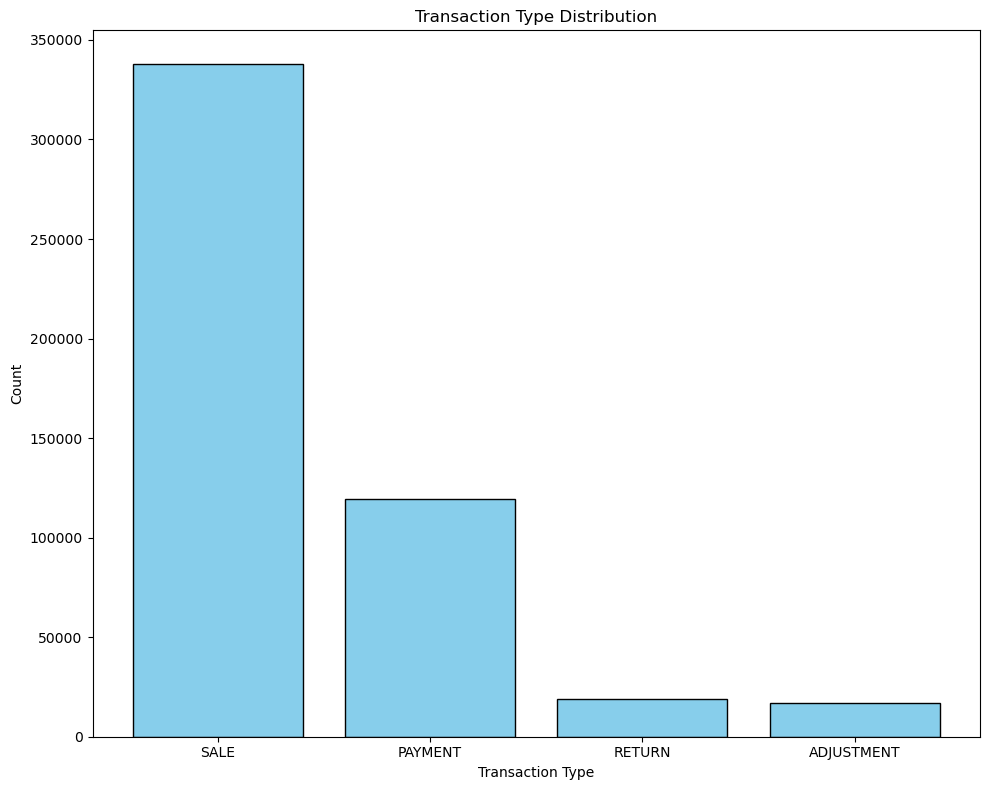

Transaction type distribution statistics:
transaction_type
SALE          337923
PAYMENT       119303
RETURN         18991
ADJUSTMENT     17119
Name: count, dtype: int64


In [43]:
import matplotlib.pyplot as plt


transaction_type_counts = df['transaction_type'].value_counts()

plt.figure(figsize=(10, 8))
plt.bar(transaction_type_counts.index, transaction_type_counts.values, color='skyblue', edgecolor='black')
plt.title('Transaction Type Distribution')
plt.xlabel('Transaction Type')
plt.ylabel('Count')


plt.tight_layout()
plt.show()

print(f"Transaction type distribution statistics:\n{transaction_type_counts}")


Account aggregation statistics:
  current_account_nbr  total_amount   avg_amount  transaction_count  transaction_type_count
0    00gwujJkd597VxLd         25.90    25.900000                  1                       1
1    00iP5U82D8XwVQ9G       9851.78    14.403187                684                     684
2    00oyr3QppAzjLws4       2015.82    77.531538                 26                      26
3    02WRVV8yusgcZWLW      10440.58  1044.058000                 10                      10
4    033o9yHYen3xoz6k      24716.89   392.331587                 63                      63


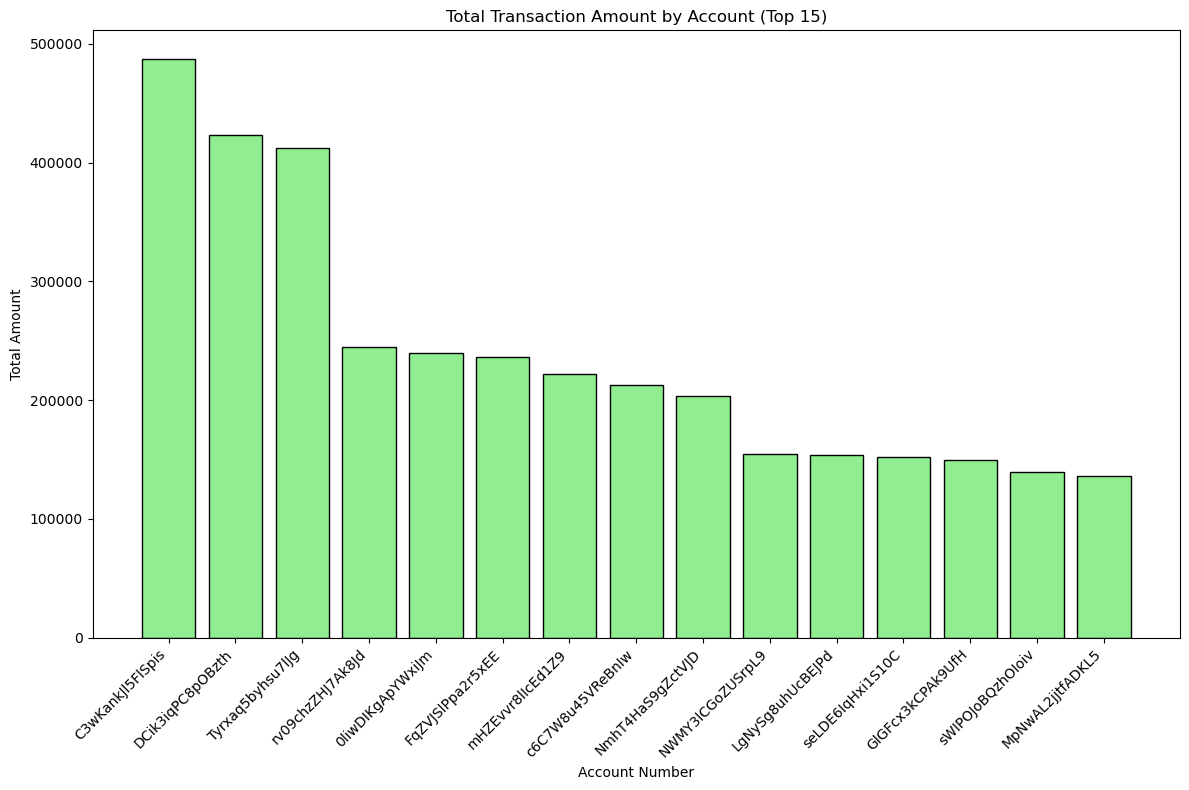

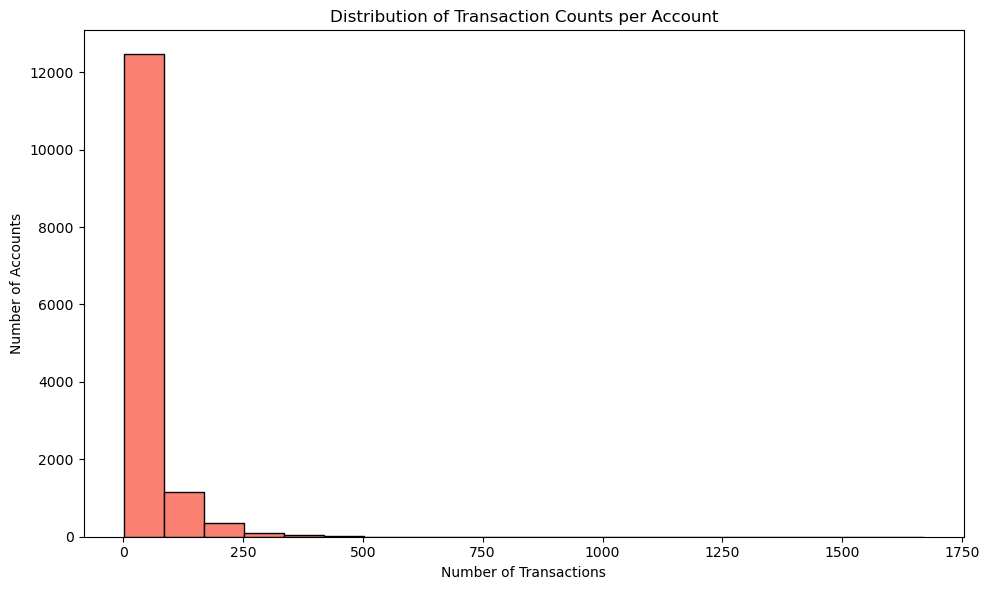

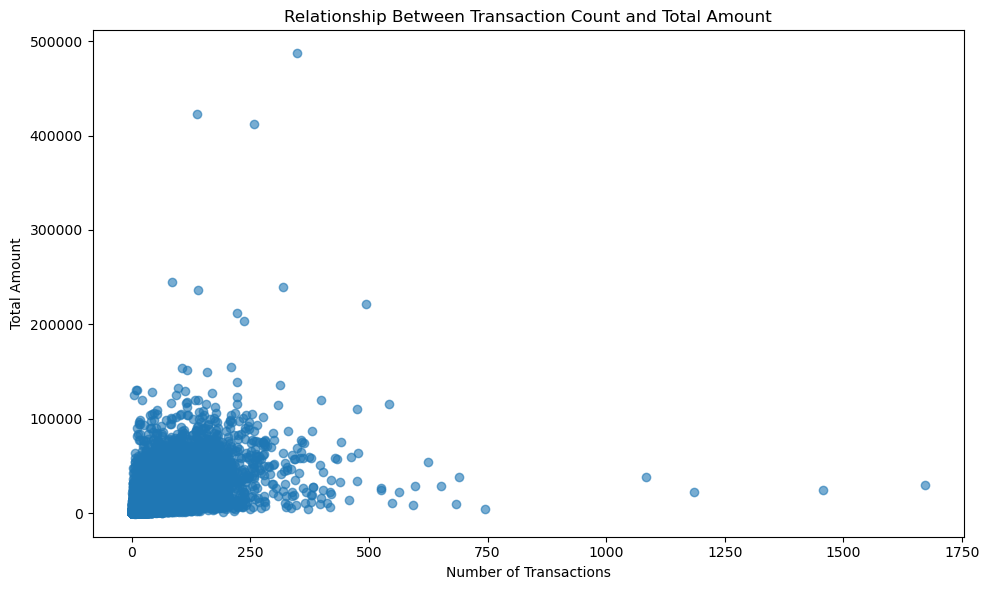


Transaction type distribution by account:
transaction_type     ADJUSTMENT  PAYMENT  RETURN  SALE
current_account_nbr                                   
00gwujJkd597VxLd              0        0       0     1
00iP5U82D8XwVQ9G              1       13       4   666
00oyr3QppAzjLws4              0       13       2    11
02WRVV8yusgcZWLW              0        3       1     6
033o9yHYen3xoz6k              0       12       1    50


<Figure size 1200x800 with 0 Axes>

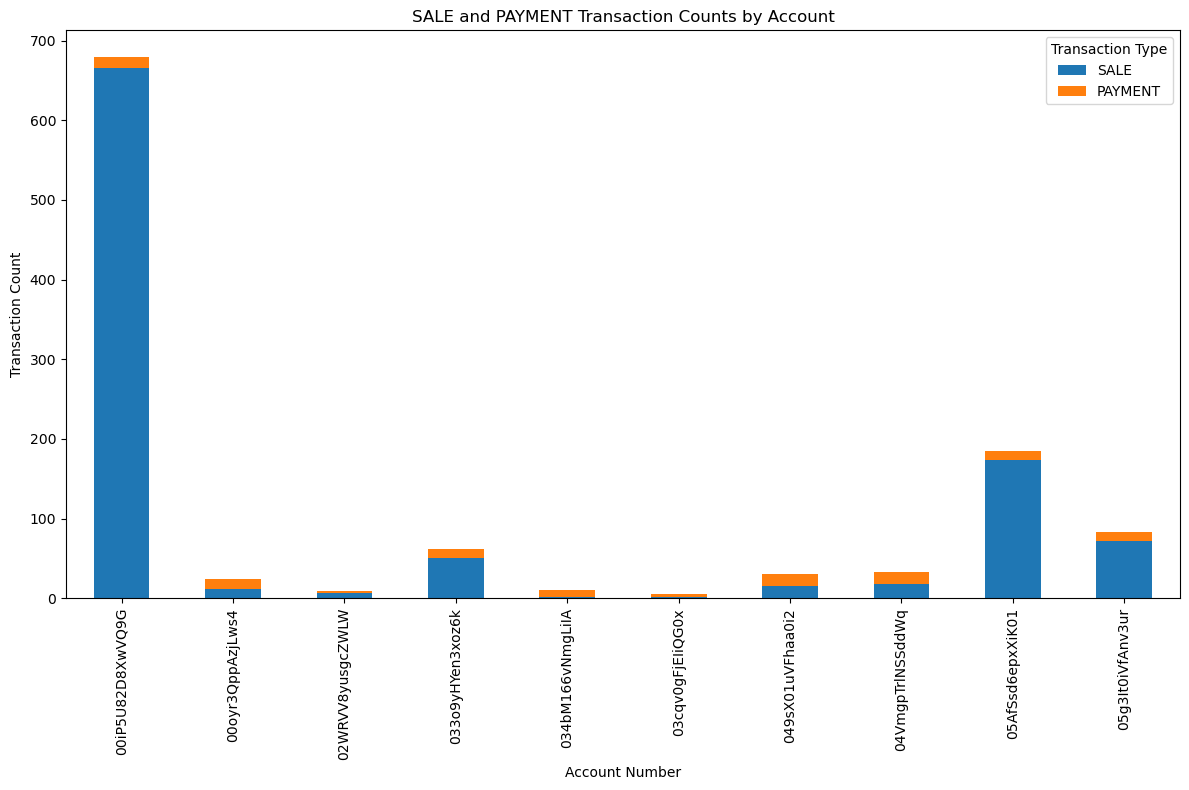

In [44]:
account_summary = df.groupby('current_account_nbr').agg({
    'transaction_amt': ['sum', 'mean', 'count'],
    'transaction_type': 'count'
}).reset_index()


account_summary.columns = ['current_account_nbr', 'total_amount', 'avg_amount', 'transaction_count', 'transaction_type_count']

print("Account aggregation statistics:")
print(account_summary.head())

plt.figure(figsize=(12, 8))
top_accounts = account_summary.sort_values('total_amount', ascending=False).head(15)
plt.bar(top_accounts['current_account_nbr'], top_accounts['total_amount'], color='lightgreen', edgecolor='black')
plt.title('Total Transaction Amount by Account (Top 15)')
plt.xlabel('Account Number')
plt.ylabel('Total Amount')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

plt.figure(figsize=(10, 6))
plt.hist(account_summary['transaction_count'], bins=20, color='salmon', edgecolor='black')
plt.title('Distribution of Transaction Counts per Account')
plt.xlabel('Number of Transactions')
plt.ylabel('Number of Accounts')
plt.tight_layout()

plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(account_summary['transaction_count'], account_summary['total_amount'], alpha=0.6)
plt.title('Relationship Between Transaction Count and Total Amount')
plt.xlabel('Number of Transactions')
plt.ylabel('Total Amount')
plt.tight_layout()

plt.show()

transaction_type_by_account = df.groupby(['current_account_nbr', 'transaction_type']).size().unstack(fill_value=0)
print("\nTransaction type distribution by account:")
print(transaction_type_by_account.head())

if 'SALE' in transaction_type_by_account.columns and 'PAYMENT' in transaction_type_by_account.columns:
    active_accounts = transaction_type_by_account[
        (transaction_type_by_account['SALE'] > 0) & 
        (transaction_type_by_account['PAYMENT'] > 0)
    ].head(10).index
    
    plt.figure(figsize=(12, 8))
    transaction_type_by_account.loc[active_accounts, ['SALE', 'PAYMENT']].plot(
        kind='bar', stacked=True, figsize=(12, 8)
    )
    plt.title('SALE and PAYMENT Transaction Counts by Account')
    plt.xlabel('Account Number')
    plt.ylabel('Transaction Count')
    plt.legend(title='Transaction Type')
    plt.tight_layout()
    plt.savefig('sale_payment_by_account.png', dpi=300)
    plt.show()


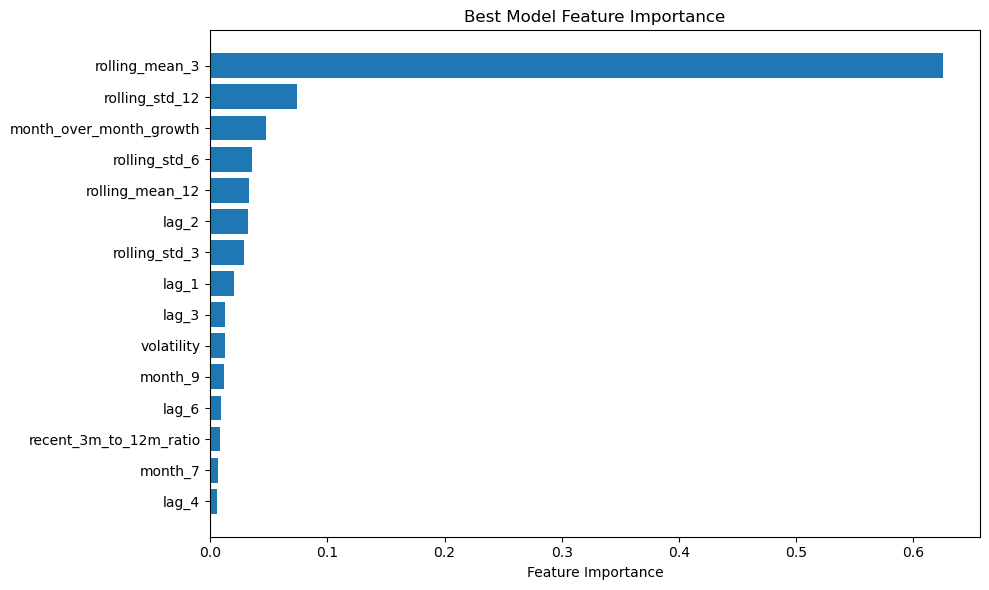

In [45]:
import matplotlib.pyplot as plt

features = [
    "rolling_mean_3", "rolling_std_12", "month_over_month_growth",
    "rolling_std_6", "rolling_mean_12", "lag_2", "rolling_std_3",
    "lag_1", "lag_3", "volatility", "month_9", "lag_6",
    "recent_3m_to_12m_ratio", "month_7", "lag_4"
]
importance = [
    0.625696, 0.074097, 0.047190, 0.035833, 0.033207,
    0.032533, 0.028737, 0.020564, 0.012847, 0.012221,
    0.012129, 0.009346, 0.008032, 0.007053, 0.005957
]

features = features[::-1]
importance = importance[::-1]

plt.figure(figsize=(10, 6))
plt.barh(features, importance)
plt.xlabel("Feature Importance")
plt.title("Best Model Feature Importance")
plt.tight_layout()
plt.show()

In [46]:
df = pd.read_csv("q4_2025_account_totals.csv")
df.columns

Index(['current_account_nbr', 'total_q4_spending'], dtype='object')

In [47]:
df_user = pd.read_csv("../data/data/syf_id_20250325.csv")
df_user.columns

Index(['ds_id', 'account_nbr_pty', 'confidence_level', 'open_date', 'closed_date'], dtype='object')

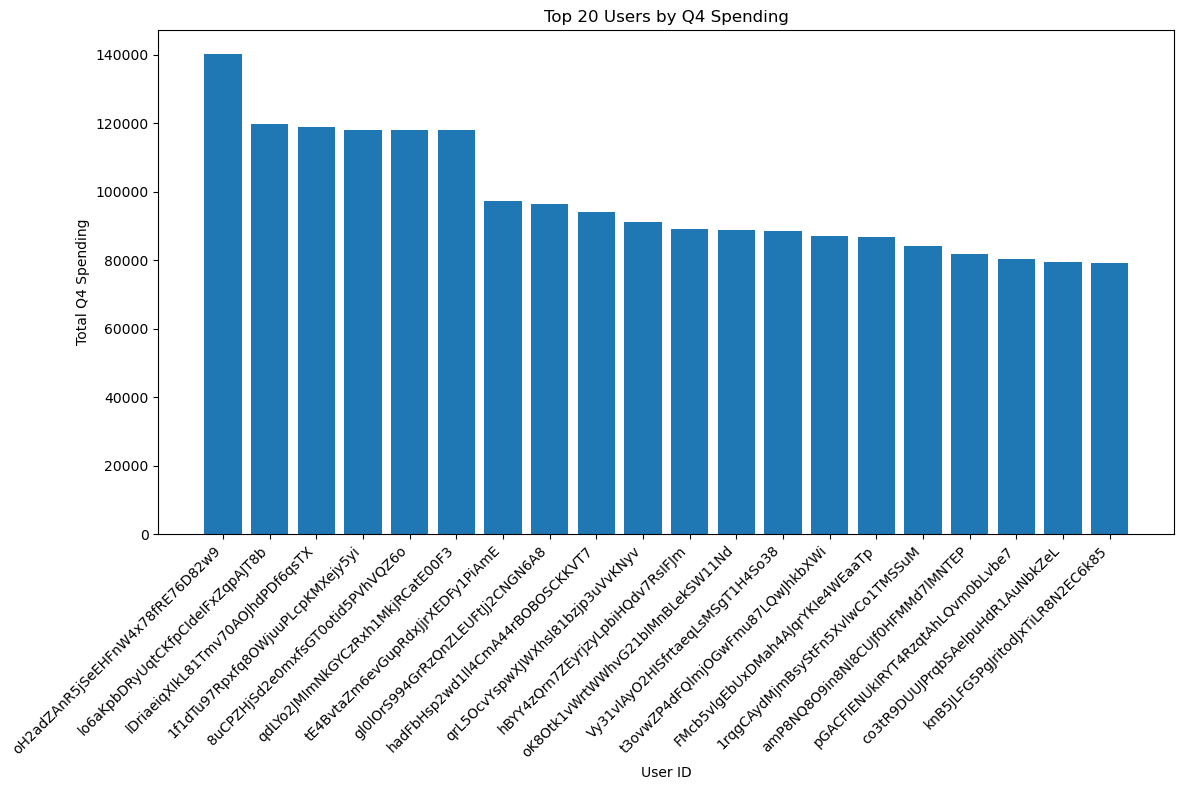

In [48]:
df_user_renamed = df_user.rename(columns={'account_nbr_pty': 'current_account_nbr'})
merged_df = pd.merge(df, df_user_renamed, on='current_account_nbr', how='left')
unmatched_accounts = merged_df[merged_df['ds_id'].isna()]
if not unmatched_accounts.empty:
    print(f"Warning: {len(unmatched_accounts)} accounts could not be matched to user IDs")
user_spending = merged_df.groupby('ds_id')['total_q4_spending'].sum().reset_index()

user_account_count = merged_df.groupby('ds_id')['current_account_nbr'].nunique().reset_index()
user_account_count.rename(columns={'current_account_nbr': 'account_count'}, inplace=True)

user_analysis = pd.merge(user_spending, user_account_count, on='ds_id')

top_spenders = user_analysis.sort_values('total_q4_spending', ascending=False).head(20)

plt.figure(figsize=(12, 8))
bars = plt.bar(top_spenders['ds_id'].astype(str), top_spenders['total_q4_spending'])


plt.title('Top 20 Users by Q4 Spending')
plt.xlabel('User ID')
plt.ylabel('Total Q4 Spending')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

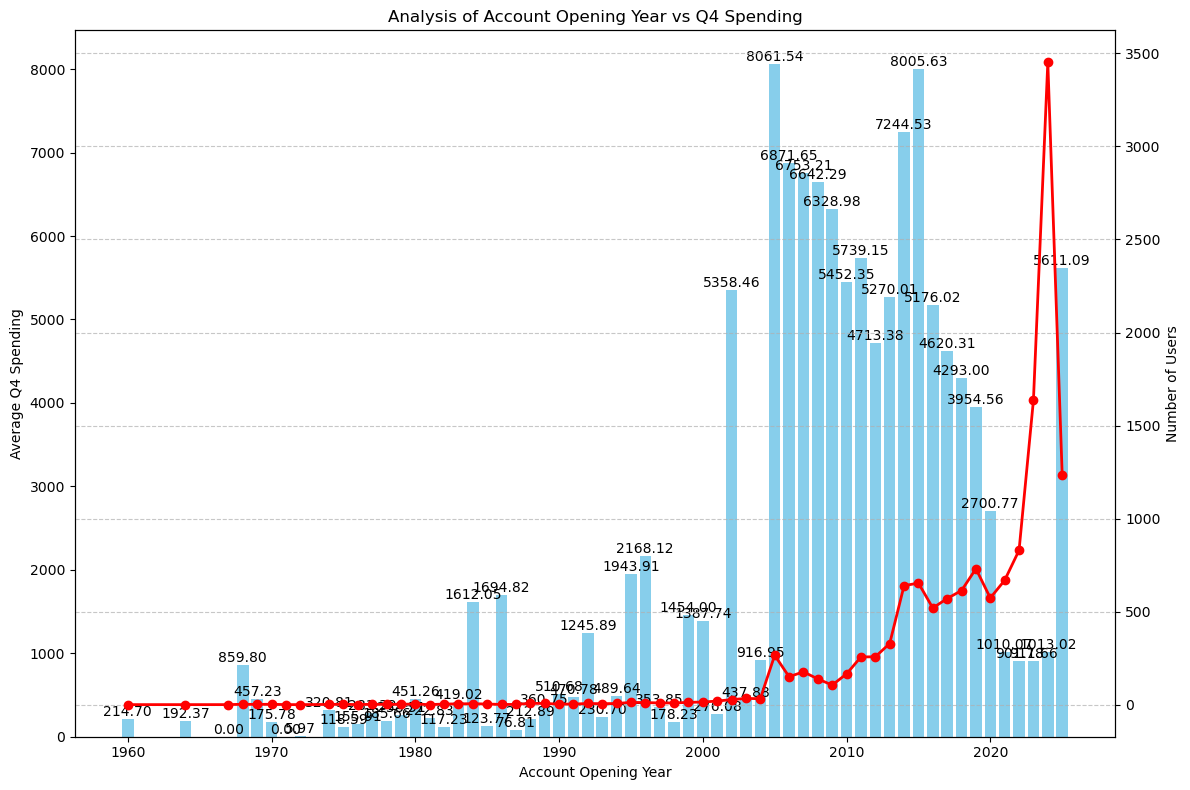

/var/folders/_v/94bcg20s3v31cvmnrlz937c80000gn/T/ipykernel_87892/3942758462.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_spending = user_spending_with_age.groupby('age_group')['total_q4_spending'].agg(['mean', 'count']).reset_index()


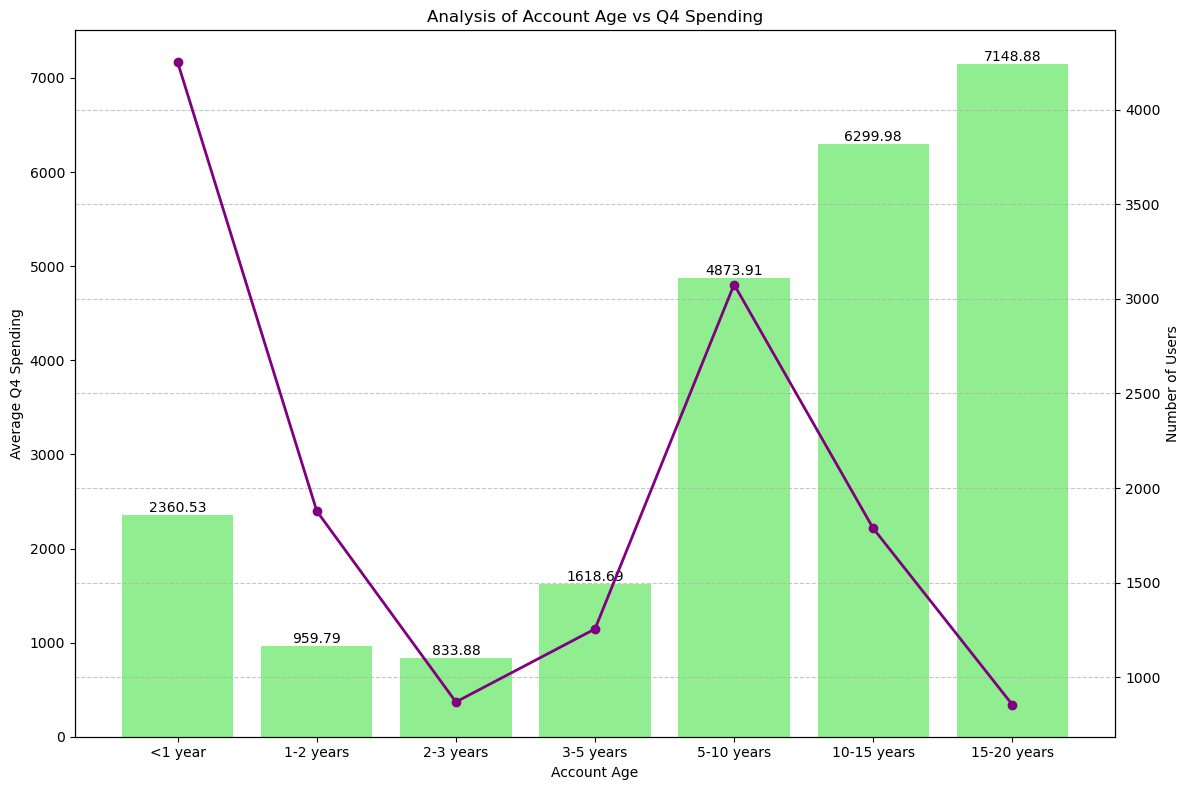

In [49]:

df_user_renamed['open_date'] = pd.to_datetime(df_user_renamed['open_date'])

df_user_renamed['open_year'] = df_user_renamed['open_date'].dt.year

user_spending_with_open_date = pd.merge(user_spending, 
                                        df_user_renamed[['ds_id', 'open_year']].drop_duplicates(), 
                                        on='ds_id', how='left')

yearly_avg_spending = user_spending_with_open_date.groupby('open_year')['total_q4_spending'].agg(['mean', 'count']).reset_index()
yearly_avg_spending.columns = ['Opening Year', 'Average Q4 Spending', 'User Count']

plt.figure(figsize=(12, 8))
ax1 = plt.gca()
bars = ax1.bar(yearly_avg_spending['Opening Year'], yearly_avg_spending['Average Q4 Spending'], color='skyblue')
ax1.set_xlabel('Account Opening Year')
ax1.set_ylabel('Average Q4 Spending')

ax2 = ax1.twinx()
ax2.plot(yearly_avg_spending['Opening Year'], yearly_avg_spending['User Count'], color='red', marker='o', linestyle='-', linewidth=2)
ax2.set_ylabel('Number of Users')

for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}',
            ha='center', va='bottom', rotation=0)

plt.title('Analysis of Account Opening Year vs Q4 Spending')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

current_date = pd.to_datetime('2025-03-25')
df_user_renamed['account_age_years'] = (current_date - df_user_renamed['open_date']).dt.days / 365.25


user_spending_with_age = pd.merge(user_spending, 
                                  df_user_renamed[['ds_id', 'account_age_years']].drop_duplicates(), 
                                  on='ds_id', how='left')


bins = [0, 1, 2, 3, 5, 10, 15, 20]
labels = ['<1 year', '1-2 years', '2-3 years', '3-5 years', '5-10 years', '10-15 years', '15-20 years']
user_spending_with_age['age_group'] = pd.cut(user_spending_with_age['account_age_years'], bins=bins, labels=labels)


age_group_spending = user_spending_with_age.groupby('age_group')['total_q4_spending'].agg(['mean', 'count']).reset_index()
age_group_spending.columns = ['Account Age', 'Average Q4 Spending', 'User Count']


plt.figure(figsize=(12, 8))
ax1 = plt.gca()
bars = ax1.bar(age_group_spending['Account Age'], age_group_spending['Average Q4 Spending'], color='lightgreen')
ax1.set_xlabel('Account Age')
ax1.set_ylabel('Average Q4 Spending')


ax2 = ax1.twinx()
ax2.plot(age_group_spending['Account Age'], age_group_spending['User Count'], color='purple', marker='o', linestyle='-', linewidth=2)
ax2.set_ylabel('Number of Users')


for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}',
            ha='center', va='bottom', rotation=0)

plt.title('Analysis of Account Age vs Q4 Spending')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

